# Delhi Air Quality Index (AQI) / (Respirable Suspended Particulate Matter < 2.5 micrometers) RSPM 2.5 Problem & Predicting the peak using POC on ARIMA/FbProphet

Problem: Every year there is horrible air quality in Delhi around Nov-Dec, which contributes to the numerous road accidents due to low visiblity and creates a health hazard for an already polluted city.

RSPM - Respirable Suspended Particulate Matter with size 2.5 micrometers and lower is the main culprit.

There are varied reasons for this phenomenon e.g.:
* Setting of winter-cold air in the lower atmosphere creates a thick blanket which traps pollution.
* Farmers burning left-over crops in-around the same time, adding soot and other particulate matters.
* General pollution from chemicals used in fireworks(this was a huge debate point and Supreme Court of India banned fireworks celebration on Diwali in 2018 - but still the AQI was below breathable and there was no improvement)

Albeit, there are compunding effects from various sources contributing to the detoriation of Air Quality Index of Delhi.
Below news links de-lineate the scope of the problem.

News Links:
    
[Delhi_Harmful_Affect_on Health](https://www.hindustantimes.com/fitness/delhi-air-pollution-what-are-its-harmful-effects-on-health-and-how-to-cope-with-it/story-Ky1d61nVsqrDFKIyEmDzwO.html)

[Delhi_Public_Health_Crisis](https://www.theguardian.com/world/2018/dec/24/delhis-worst-air-pollution-this-year-raises-fear-of-public-health-crisis)

[Living in Delhi is as smoking 45 cigarettes a day](https://qz.com/india/1124049/air-pollution-in-new-delhi-has-the-health-effect-of-smoking-45-cigarettes-a-day/)
         

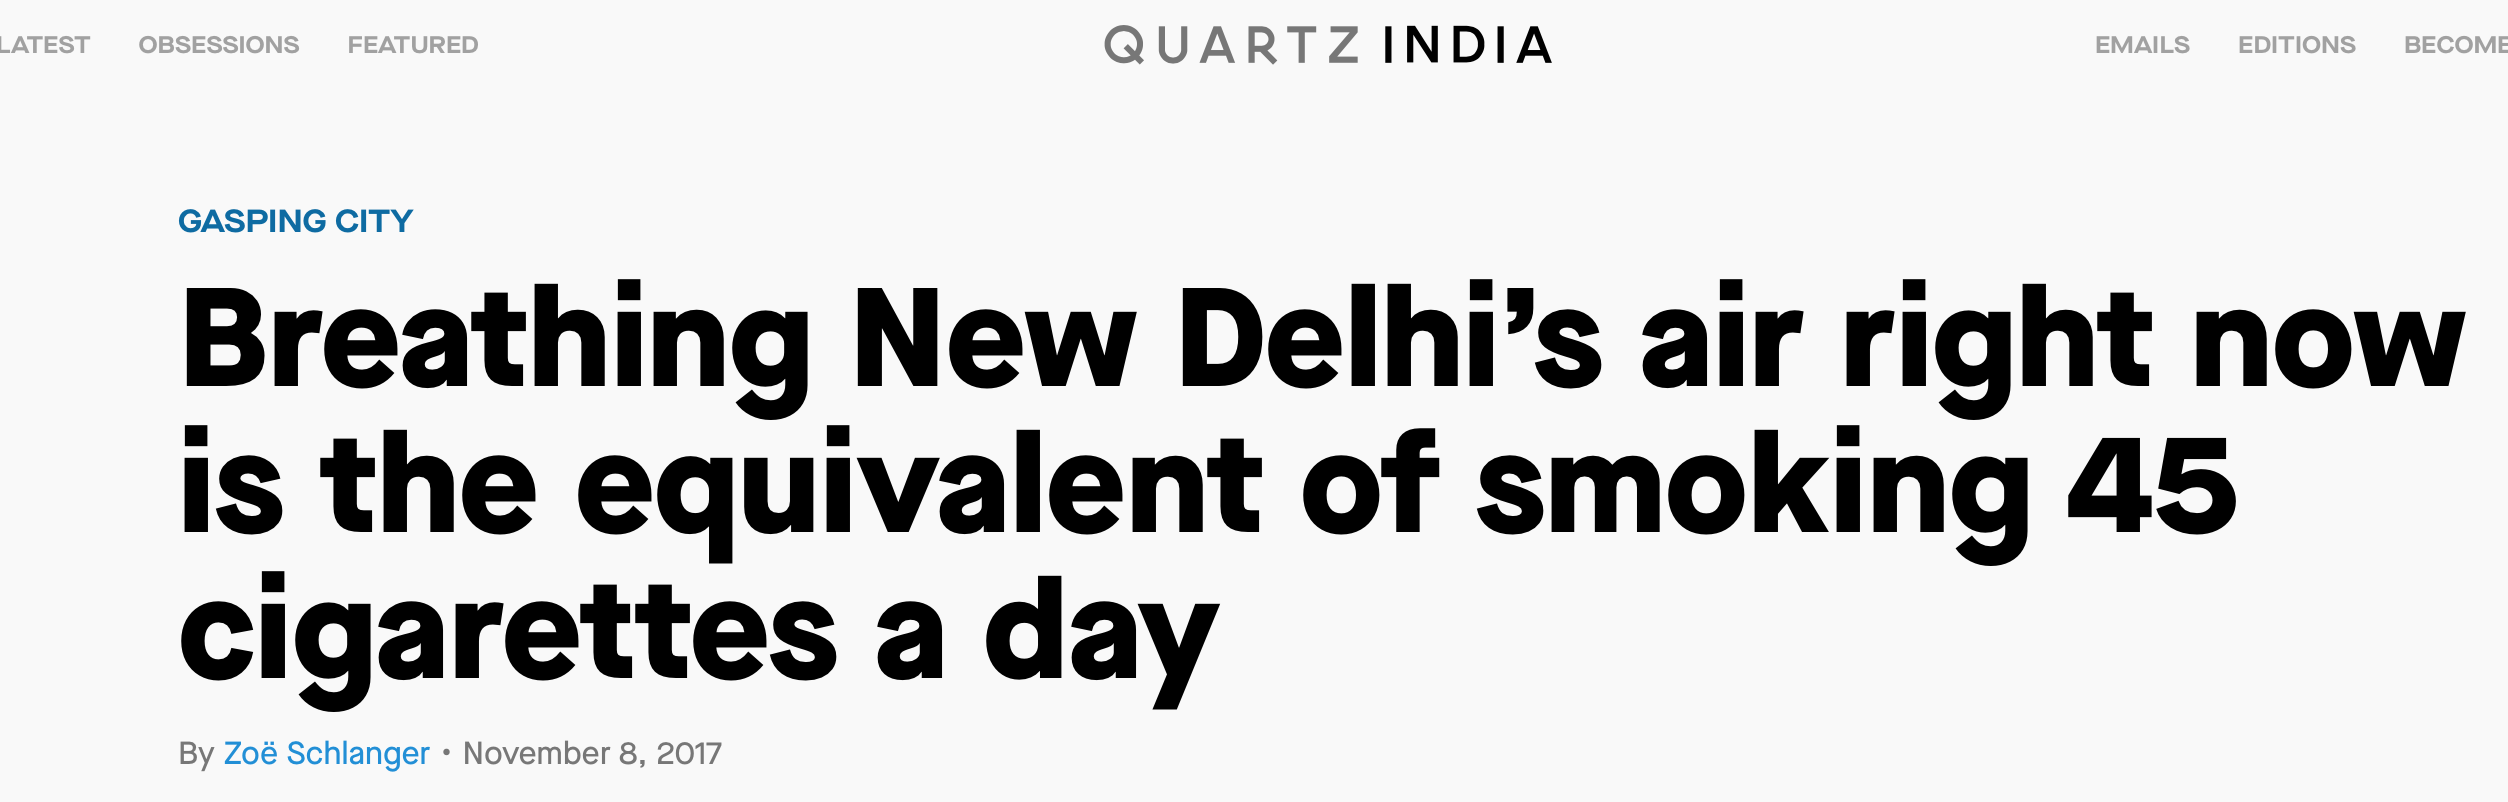

In [1]:
from IPython.display import Image
Image("Delhi_AQI.png")

Inference: This POC is an effort to predict the peak of the RSPM - Respirable Suspended Particulate Matter in Delhi Air by analyzing the
            timeseries behaviour.
      

Goal: If there is model that can analyze the timeseries behaviour and can predcit the worse levels of RSPM correctly on a weekly granualarity, the alerting mechanism
        can be generated to predict the Air Quality in advance i.e. effectively predicting the RSPM & defining Air Quality Index of Delhi 1 or 2 weeks before the peak.
    

In [2]:
from IPython.display import HTML
from IPython.display import Image, HTML
from IPython.display import Image, display

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
#Loading necessary Libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import sys
import io
import requests
print('Python version -- ', sys.version)
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from fbprophet import Prophet
import tensorflow as tf
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

print('numpy version -- ', np.__version__) 
print('pandas version -- ',pd.__version__)
print('matplotlib version --', plt.__version__)
print('seaborn version -- ', sns.__version__)
print('tensorflow version -- ', tf.__version__)

Python version --  3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
numpy version --  1.14.2
pandas version --  0.22.0
matplotlib version -- 1.14.2
seaborn version --  0.7.1
tensorflow version --  1.5.0


Reading Data

In [4]:
paths = ['http://dosairnowdata.org/dos/historical/NewDelhi/2019/NewDelhi_PM2.5_2019_YTD.csv',
        'http://dosairnowdata.org/dos/historical/NewDelhi/2018/NewDelhi_PM2.5_2018_YTD.csv',
        'http://dosairnowdata.org/dos/historical/NewDelhi/2017/NewDelhi_PM2.5_2017_YTD.csv',
        'http://dosairnowdata.org/dos/historical/NewDelhi/2016/NewDelhi_PM2.5_2016_YTD.csv',
        'http://dosairnowdata.org/dos/historical/NewDelhi/2015/NewDelhi_PM2.5_2015_YTD.csv']

In [5]:
DF = pd.DataFrame()
for path in paths:
    url=path
    temp_df =requests.get(url).content
    temp_df =pd.read_csv(io.StringIO(temp_df.decode('utf-8')),sep=',')
    DF = pd.concat([DF,temp_df])

Sample Data

In [6]:
DF.tail(3)

,Site,Parameter,Date (LT),Year,Month,Day,Hour,NowCast Conc.,AQI,AQI Category,Raw Conc.,Conc. Unit,Duration,QC Name
8757,New Delhi,PM2.5 - Principal,2015-12-31 10:00 PM,2015,12,31,22,291.7,342,Hazardous,373.0,UG/M3,1 Hr,Valid
8758,New Delhi,PM2.5 - Principal,2015-12-31 11:00 PM,2015,12,31,23,317.8,368,Hazardous,344.0,UG/M3,1 Hr,Valid
8759,New Delhi,PM2.5 - Principal,2016-01-01 12:00 AM,2016,1,1,0,337.9,388,Hazardous,358.0,UG/M3,1 Hr,Valid


Total rows and columns in data

In [7]:
DF.shape

(35943, 14)

Sanitizing the Data and converting into Timeseries

In [8]:
cols_drop = ['Site','Parameter','Conc. Unit','Duration','QC Name','Unit','Year','Month','Day','Hour','AQI','AQI Category','Raw Conc.']
cols_keep = ['NowCast Conc.','24-hr. Midpoint Avg. Conc.']

def sanitize_data(data):
    for col in data.columns:
        if col in cols_drop:
            data.drop(col, axis=1, inplace=True)
        if col in cols_keep:
            data.rename(columns={'Date (LT)':'Timestamp','NowCast Conc.': 'Con'}, inplace=True)
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data = data.drop_duplicates(subset='Timestamp', keep='last')
    data[data.duplicated(['Timestamp'], keep=False)]
    data = data[(data.Con > 0)]
    data = data.sort_values(by='Timestamp', ascending = False)
    return (data)

In [9]:
DF = sanitize_data(DF)

In [10]:
ts = DF.groupby(['Timestamp']).mean().reset_index()
ts['Timestamp'] = pd.to_datetime(ts.Timestamp)
ts = ts.set_index('Timestamp')
ts = ts.resample('T').ffill().reindex(pd.date_range(ts.index[0],ts.index[-1],freq='H'))

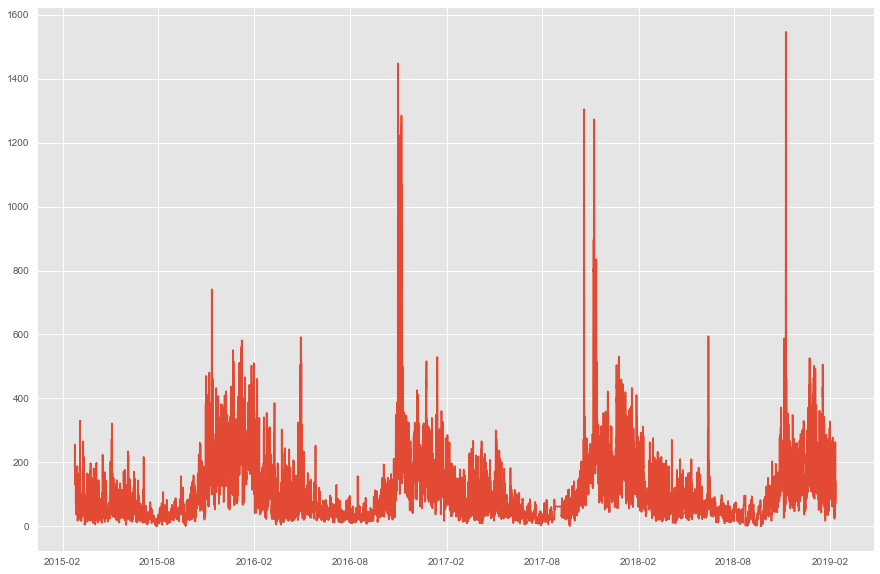

In [11]:
plt.plot(ts)
#plt.show()

Daily & Weekly Moving Average of the hourly data, indicating to decide on the optimum granularity

In [12]:
#Simple Moving Average Daily, Weekly, Montly
ts['MA1'] = pd.rolling_mean(ts.Con, window = 24*1)
ts['MA7'] = pd.rolling_mean(ts.Con, window = 24*7)
ts['MA30'] = pd.rolling_mean(ts.Con, window = 24*30)

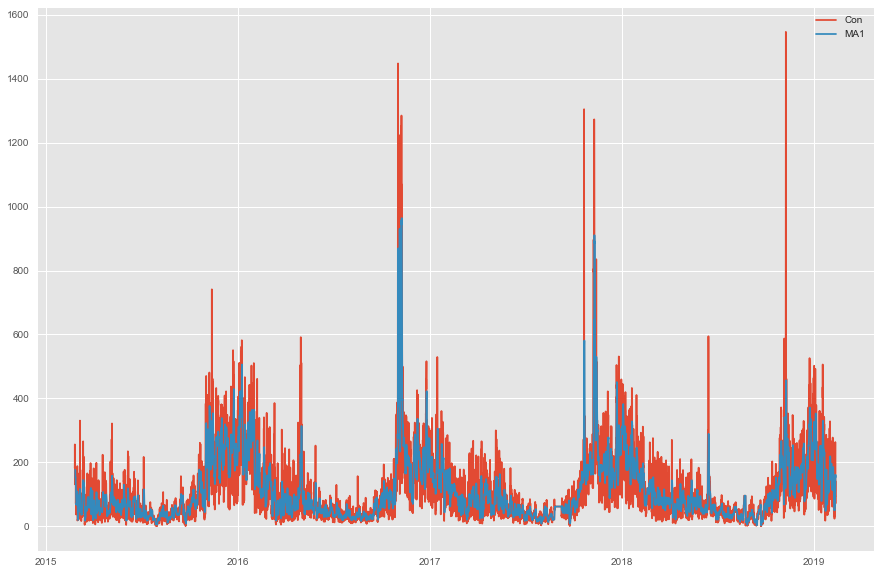

In [13]:
ts.plot(kind ='line', y=['Con','MA1'])

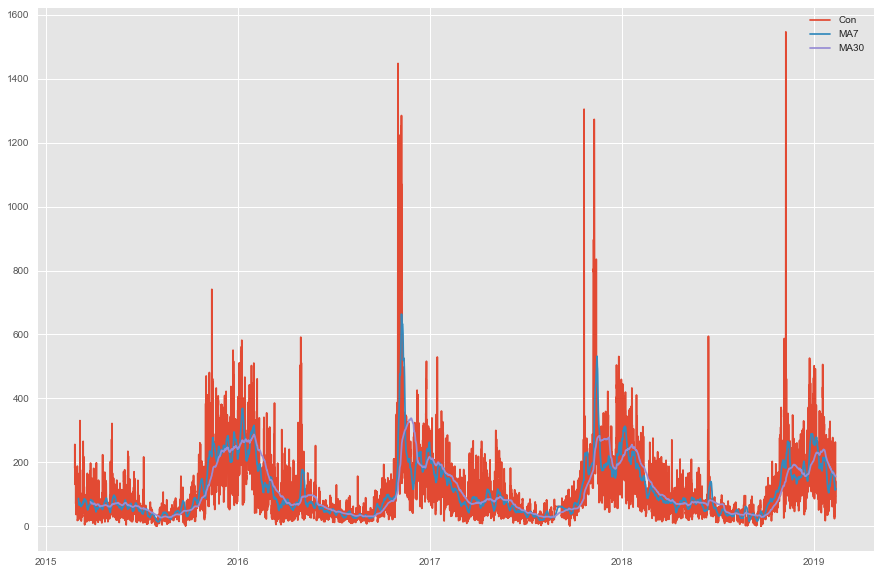

In [14]:
ts.plot(kind ='line', y=['Con','MA7','MA30'])

The peaks are highly seasonal, Thus will use ARIMA with 365 days seasonal component

# Initial POC on Hourly Data with ARIMA

In [15]:
#Function to check statioanrity
def test_stationarity(timeseries):
    from statsmodels.tsa.stattools import adfuller
    biweeklymean = pd.rolling_mean(timeseries, window=14)
    biweeklystd = pd.rolling_std(timeseries, window=14)

    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(biweeklymean, color='red', label='Bi-Weekly Mean')
    std = plt.plot(biweeklystd, color='black', label = 'Bi-Weekly Std')
    plt.legend(loc='best')
    plt.title('Bi-Weekly Mean & Standard Deviation')
    plt.show()
    
    print('Results of Dickey-Fuller Test:')
    adftest = adfuller(timeseries, autolag='AIC')
    adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    print(adfoutput)

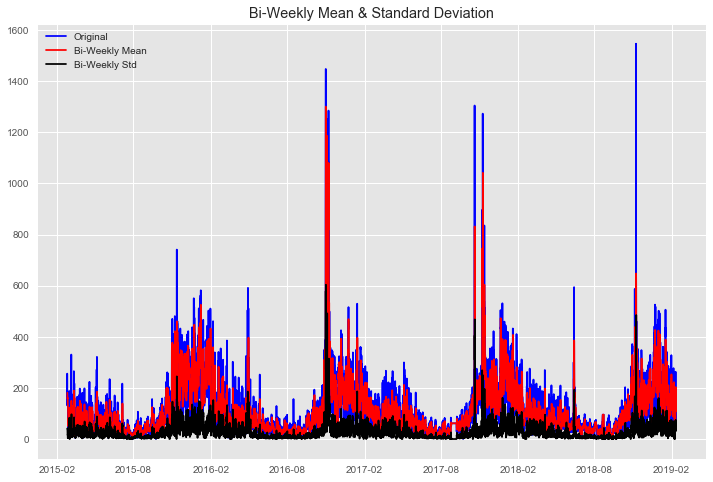

Results of Dickey-Fuller Test:
Test Statistic                -9.878254e+00
p-value                        3.830799e-17
#Lags Used                     5.200000e+01
Number of Observations Used    3.469500e+04
Critical Value (1%)           -3.430538e+00
Critical Value (5%)           -2.861623e+00
Critical Value (10%)          -2.566814e+00
dtype: float64


In [16]:
test_stationarity(ts.Con)

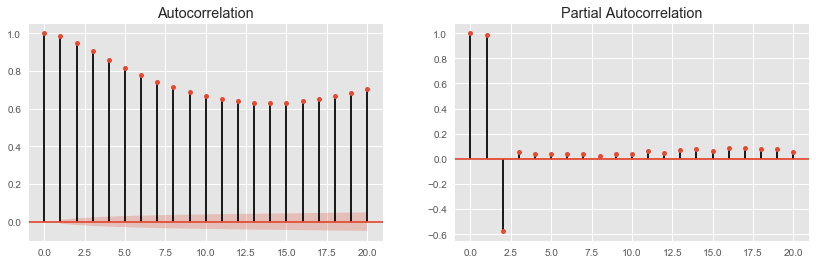

In [17]:
#Checking AR() & MA() terms
fig, axes = plt.subplots(1, 2, figsize=(14,4))
fig = sm.graphics.tsa.plot_acf(ts.Con, lags=20, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(ts.Con, lags=20, ax=axes[1])

Introducing a Diff or Lag to make data stationary

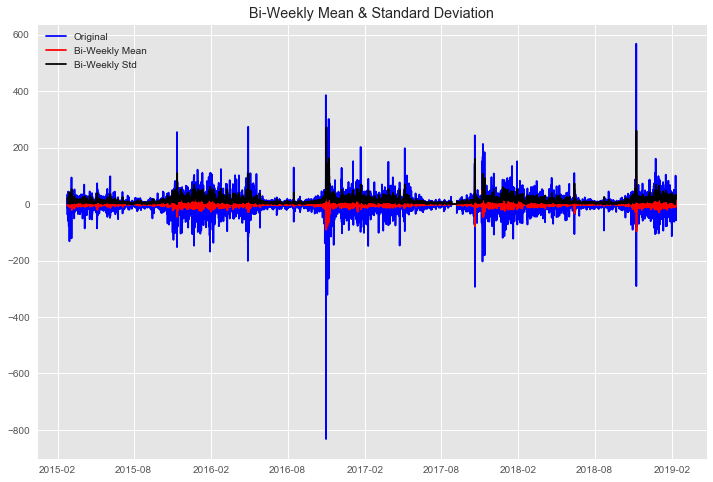

Results of Dickey-Fuller Test:
Test Statistic                   -32.678862
p-value                            0.000000
#Lags Used                        52.000000
Number of Observations Used    34694.000000
Critical Value (1%)               -3.430538
Critical Value (5%)               -2.861623
Critical Value (10%)              -2.566814
dtype: float64


In [18]:
ts['val_diff1'] = ts.Con - ts.Con.shift(1)
test_stationarity(ts.val_diff1.dropna(inplace=False))

In [19]:
#Creating Train, Test
split = len(ts) - 30
train = ts[0:split]
test = ts[split:]
print('Dataset %d, Test %d' % (len(train), len(test)))

Dataset 34718, Test 30


In [20]:
#Finding ARIMA order
for p in range(5):
    for d in range(2):
        for q in range(6):
            try:
                arima_mod=sm.tsa.ARIMA(np.asarray(train.Con),(p,d,q)).fit(transparams=True)
                aic=arima_mod.aic
                param= (p,d,q) 
                print('ARIMA{} --- AIC {}'.format(param, aic))
                aic.append(aic)
                pdq.append(param)
            except:
                pass

ARIMA(0, 0, 0) --- AIC 425294.4381204847
ARIMA(0, 0, 1) --- AIC 381740.2132847266
ARIMA(0, 1, 0) --- AIC 306533.23551248567
ARIMA(0, 1, 1) --- AIC 295676.5095315146
ARIMA(0, 1, 2) --- AIC 293457.59735644585
ARIMA(0, 1, 3) --- AIC 293063.11690668203
ARIMA(0, 1, 4) --- AIC 293027.54483508796
ARIMA(0, 1, 5) --- AIC 293029.3333030726
ARIMA(1, 0, 0) --- AIC 306261.7770610933
ARIMA(1, 0, 1) --- AIC 295227.714126512
ARIMA(1, 0, 2) --- AIC 292826.9030795157
ARIMA(1, 0, 3) --- AIC 292299.61127800937
ARIMA(1, 0, 4) --- AIC 292190.8112580062
ARIMA(1, 0, 5) --- AIC 292165.9736985979
ARIMA(1, 1, 0) --- AIC 293379.27913064184
ARIMA(1, 1, 1) --- AIC 293170.1602096483
ARIMA(1, 1, 2) --- AIC 293075.42678446835
ARIMA(1, 1, 3) --- AIC 292279.58339215524
ARIMA(1, 1, 4) --- AIC 291560.0842420978
ARIMA(1, 1, 5) --- AIC 291303.93686341646
ARIMA(2, 0, 0) --- AIC 292358.22451659525
ARIMA(2, 0, 1) --- AIC 292255.56403892883
ARIMA(2, 0, 2) --- AIC 292211.3332878018
ARIMA(2, 0, 3) --- AIC 292274.4606327712
ARIMA(

/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 1) --- AIC 291012.17303091264
ARIMA(3, 0, 2) --- AIC 291013.78797071846
ARIMA(3, 0, 3) --- AIC 291002.290673324
ARIMA(3, 0, 4) --- AIC 290804.3470989138
ARIMA(3, 0, 5) --- AIC 290721.0910114881
ARIMA(3, 1, 0) --- AIC 292968.09569008375
ARIMA(3, 1, 1) --- AIC 291039.2971886053
ARIMA(3, 1, 2) --- AIC 291038.9949405127
ARIMA(3, 1, 3) --- AIC 291039.2703433739
ARIMA(3, 1, 4) --- AIC 291035.153833288
ARIMA(3, 1, 5) --- AIC 290895.4756717718
ARIMA(4, 0, 0) --- AIC 292179.72324938845
ARIMA(4, 0, 1) --- AIC 291013.84718105703
ARIMA(4, 0, 2) --- AIC 291014.0872883485
ARIMA(4, 0, 3) --- AIC 291013.21530336683
ARIMA(4, 0, 5) --- AIC 290723.0666958853
ARIMA(4, 1, 0) --- AIC 292844.3831979642
ARIMA(4, 1, 1) --- AIC 291032.94793344743
ARIMA(4, 1, 2) --- AIC 290930.0940440214
ARIMA(4, 1, 3) --- AIC 289922.8493042757


In [21]:
#diff removing seasonal component of ts
def diff_ts(dataset, diff=1):
    new_ts = []
    for i in range(diff, len(dataset)):
        value = dataset[i] - dataset[i - diff]
        new_ts.append(value)
    return (np.array(new_ts))

In [22]:
# invert differenced value
def inverse_diff(history, y, diff=1):
    return (y + history[-diff])

In [23]:
seasonality = 365
ts_1 = diff_ts(ts.Con, seasonality)
# fit model
model = ARIMA(ts_1, order=(4,0,3))
model_fit = model.fit()
# print summary of fit model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                34383
Model:                     ARMA(4, 3)   Log Likelihood             -155825.634
Method:                       css-mle   S.D. of innovations             22.490
Date:                Sun, 31 Mar 2019   AIC                         311669.268
Time:                        18:43:50   BIC                         311745.276
Sample:                             0   HQIC                        311693.499
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6650      6.950      0.096      0.924     -12.956      14.286
ar.L1.y        1.6849      0.068     24.680      0.000       1.551       1.819
ar.L2.y       -0.0372      0.169     -0.220      0.8

In [24]:
forecast = model_fit.forecast(steps=30)[0]

In [25]:
# invert the differenced forecast to something usable
history = [x for x in ts.Con]
frcst = []
day = 1
for y in forecast:
    inverted = inverse_diff(history, y, seasonality)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    frcst.append(inverted)
    day += 1

Day 1: 149.379267
Day 2: 150.264453
Day 3: 144.564987
Day 4: 141.821014
Day 5: 141.306567
Day 6: 149.719577
Day 7: 155.658617
Day 8: 182.673908
Day 9: 173.197843
Day 10: 158.426564
Day 11: 181.409884
Day 12: 191.882460
Day 13: 260.499375
Day 14: 292.328857
Day 15: 231.676047
Day 16: 201.376766
Day 17: 169.493857
Day 18: 142.904225
Day 19: 97.884151
Day 20: 75.251570
Day 21: 82.181130
Day 22: 85.544276
Day 23: 86.512909
Day 24: 111.927161
Day 25: 124.459529
Day 26: 137.631605
Day 27: 148.619654
Day 28: 138.535514
Day 29: 133.460747
Day 30: 127.302569


In [26]:
frcst_df = pd.DataFrame(frcst, index=test.index)

In [27]:
test['frcst'] = frcst_df

Compairing Forecast vs Test Visually

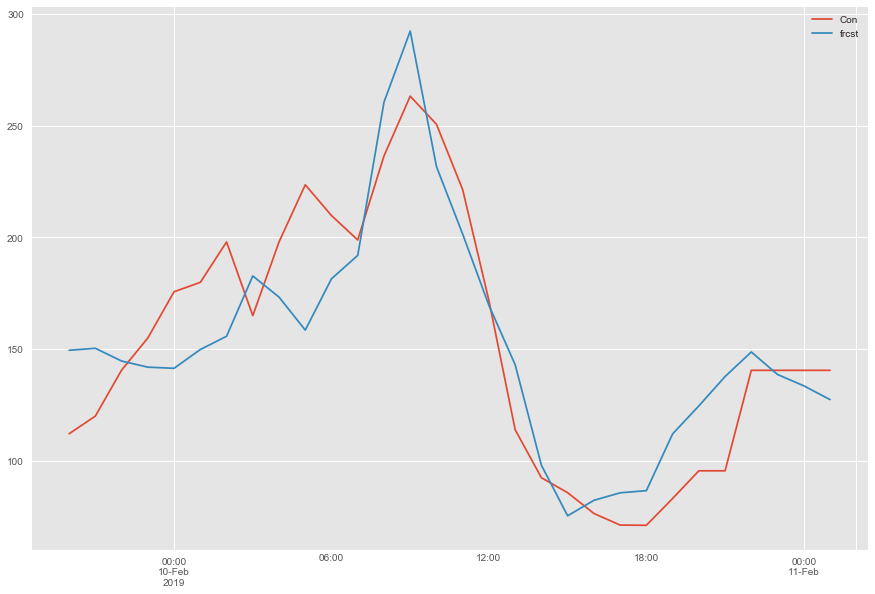

In [28]:
test.plot(kind = 'line', y = ['Con','frcst'])

In [29]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [30]:
RMSE(test.frcst,test.Con)

25.686756895334216

Pretty close, but were dealing with 2 days of hourly data. lets get to daily granularity
Also, compare with available out of the box package( FbProphet )

Now, Working with one observation per day so creating new TS

In [31]:
TS = ts.Con
TS = TS.reset_index()
TS['Date'] = TS['index'].dt.strftime('%Y-%m-%d')
TS_daily = TS.groupby(['Date']).mean()

In [32]:
#TS_daily.plot()

Trying FbProphet package and will pit it against the traditional ARIMA

In [33]:
TS_daily['Con'] = np.log(TS_daily.Con)

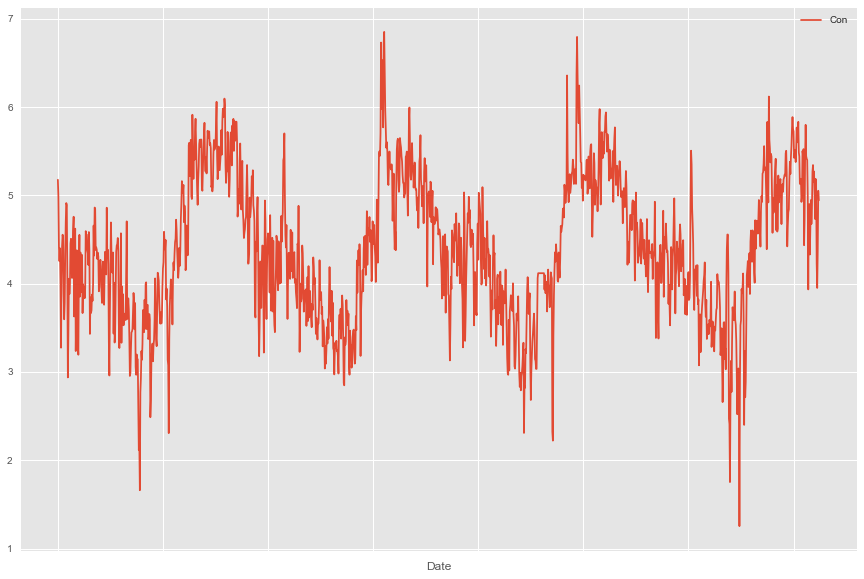

In [34]:
TS_daily.plot()

In [35]:
TS_daily = TS_daily.reset_index()
TS_daily = TS_daily.rename({'Date':'ds', 'Con':'y'}, axis='columns')
#TS_daily.drop('index', axis=1, inplace=True)

In [36]:
#TS_daily.drop('level_0', axis =1, inplace =True)

In [37]:
mod = Prophet()

In [38]:
#Creating Train, Test
split = len(TS_daily) - 30
train = TS_daily[0:split]
test = TS_daily[split:]
print('Dataset %d, Test %d' % (len(train), len(test)))

Dataset 1419, Test 30


In [39]:
mod.fit(train)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
#Forecasting for a month
forecast_1month = mod.make_future_dataframe(periods=30, freq = 'd')

In [41]:
forecast_data_1m = mod.predict(forecast_1month)

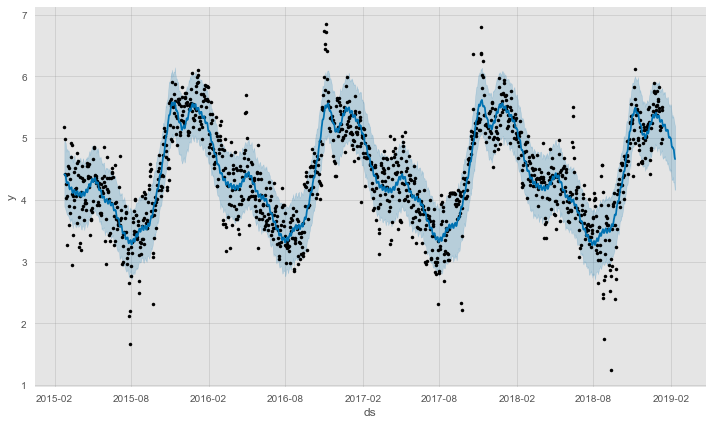

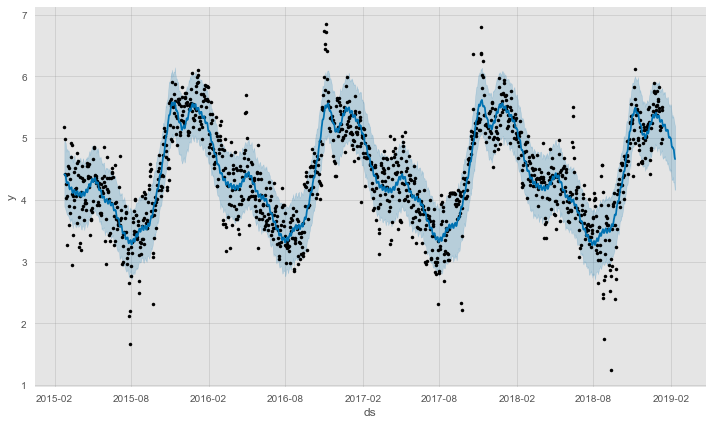

In [42]:
mod.plot(forecast_data_1m)

In [43]:
RMSE(forecast_data_1m.trend, test.y)

0.8039535099343627

# Prophet vs ARIMA

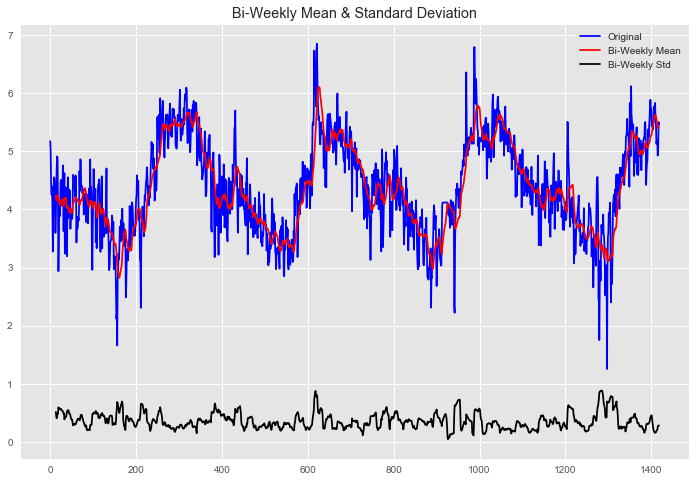

Results of Dickey-Fuller Test:
Test Statistic                   -2.556671
p-value                           0.102287
#Lags Used                       14.000000
Number of Observations Used    1404.000000
Critical Value (1%)              -3.435016
Critical Value (5%)              -2.863601
Critical Value (10%)             -2.567867
dtype: float64


In [44]:
test_stationarity(train.y)

In [45]:
#Finding ARIMA order
for p in range(5):
    for d in range(2):
        for q in range(6):
            try:
                arima_mod=sm.tsa.ARIMA(np.asarray(train.y),(p,d,q)).fit(transparams=True)
                aic=arima_mod.aic
                param= (p,d,q) 
                print('ARIMA{} --- AIC {}'.format(param, aic))
                aic.append(aic)
                pdq.append(param)
            except:
                pass

ARIMA(0, 0, 0) --- AIC 3417.5651823997605
ARIMA(0, 0, 1) --- AIC 2242.5423018412193
ARIMA(0, 0, 2) --- AIC 1818.7398162793706
ARIMA(0, 0, 4) --- AIC 1446.249092455123
ARIMA(0, 1, 0) --- AIC 1181.7711209377455
ARIMA(0, 1, 1) --- AIC 1142.431692707743
ARIMA(0, 1, 2) --- AIC 1021.3488349060704
ARIMA(0, 1, 3) --- AIC 1005.006787842949
ARIMA(0, 1, 4) --- AIC 992.3405255627613
ARIMA(0, 1, 5) --- AIC 992.2032317796929
ARIMA(1, 0, 0) --- AIC 1111.1929311552985
ARIMA(1, 0, 1) --- AIC 1098.5668091437806
ARIMA(1, 0, 2) --- AIC 1012.3389535049537
ARIMA(1, 0, 3) --- AIC 1000.5157620647028
ARIMA(1, 0, 4) --- AIC 989.5114762333178
ARIMA(1, 0, 5) --- AIC 989.7148017799805
ARIMA(1, 1, 0) --- AIC 1162.1481072570027
ARIMA(1, 1, 1) --- AIC 1004.7629245634612
ARIMA(1, 1, 2) --- AIC 991.728883525203
ARIMA(1, 1, 3) --- AIC 990.9955837439179
ARIMA(1, 1, 4) --- AIC 991.0893510621431
ARIMA(1, 1, 5) --- AIC 993.0459806087379
ARIMA(2, 0, 0) --- AIC 1105.1566039201703
ARIMA(2, 0, 1) --- AIC 1002.6749092239679
ARIM

/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 5) --- AIC 990.4048893503063
ARIMA(3, 0, 0) --- AIC 1050.4209109679086
ARIMA(3, 0, 1) --- AIC 992.2081422179954
ARIMA(3, 0, 2) --- AIC 987.3182562764378
ARIMA(3, 0, 3) --- AIC 989.2651320119421


/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 5) --- AIC 981.0281318481898
ARIMA(3, 1, 0) --- AIC 1075.02043206897
ARIMA(3, 1, 1) --- AIC 992.638173279609
ARIMA(3, 1, 2) --- AIC 991.5167468444101


/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3) --- AIC 984.9088929709778


/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 4) --- AIC 982.271563736831


/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 5) --- AIC 995.2460050148393
ARIMA(4, 0, 0) --- AIC 1045.6191954109113
ARIMA(4, 0, 1) --- AIC 990.3700013424695
ARIMA(4, 0, 2) --- AIC 989.2486607252758
ARIMA(4, 0, 3) --- AIC 982.7634618790721


/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 4) --- AIC 979.9234167271202


/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 5) --- AIC 992.3898479507557
ARIMA(4, 1, 0) --- AIC 1053.4714448844302
ARIMA(4, 1, 1) --- AIC 990.9613358825036
ARIMA(4, 1, 2) --- AIC 992.8992852121701


/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 3) --- AIC 982.586729026315


/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 4) --- AIC 991.4950192389965
ARIMA(4, 1, 5) --- AIC 996.9729539020459


/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [46]:
seasonality = 365
ts_1 = diff_ts(train.y, seasonality)
# fit model
model = ARIMA(ts_1, order=(4,1,1))
model_fit = model.fit()
# print summary of fit model
print(model_fit.summary())

/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1053
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -668.646
Method:                       css-mle   S.D. of innovations              0.456
Date:                Sun, 31 Mar 2019   AIC                           1351.293
Time:                        18:45:02   BIC                           1386.008
Sample:                             1   HQIC                          1364.454
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -0.685      0.493      -0.000       0.000
ar.L1.D.y      0.7209      0.031     23.314      0.000       0.660       0.782
ar.L2.D.y     -0.1535      0.038     -4.056      0.0

In [47]:
forecast = model_fit.forecast(steps=30)[0]

In [48]:
# invert the differenced forecast to something usable
history = [x for x in train.y]
frcst = []
day = 1
for y in forecast:
    inverted = inverse_diff(history, y, seasonality)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    frcst.append(inverted)
    day += 1

Day 1: 5.322227
Day 2: 5.277535
Day 3: 5.478959
Day 4: 4.893488
Day 5: 5.417213
Day 6: 5.594318
Day 7: 5.711758
Day 8: 5.271017
Day 9: 5.053188
Day 10: 5.234542
Day 11: 5.268446
Day 12: 5.120591
Day 13: 4.928798
Day 14: 5.143186
Day 15: 5.230204
Day 16: 5.317840
Day 17: 5.249526
Day 18: 5.016031
Day 19: 4.909095
Day 20: 4.950274
Day 21: 4.975072
Day 22: 4.613170
Day 23: 4.868017
Day 24: 5.010529
Day 25: 4.958030
Day 26: 4.795018
Day 27: 5.018454
Day 28: 5.203980
Day 29: 5.027911
Day 30: 4.657829


In [49]:
frcst_df = pd.DataFrame(frcst, index=test.index)
test['frcst'] = frcst_df

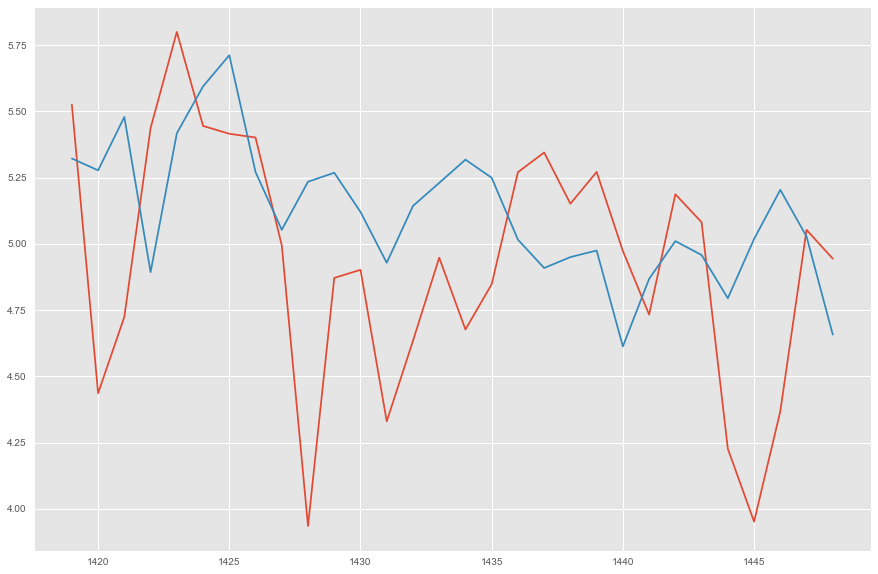

In [50]:
test.y.plot()
test.frcst.plot()

In [51]:
RMSE(test.y,test.frcst)

0.512110497498132

In [52]:
change = (0.80 - 0.51)
per_change = (change/0.80)*100
print(round(per_change, 2))

36.25


The results are better than Prophet by 36 %

# Traditional ARIMA beats FbProphet

In [53]:
TS = ts.Con
TS = TS.reset_index()
TS['Date'] = TS['index'].dt.strftime('%Y-%m-%d')
TS_daily = TS.groupby(['Date']).mean()
TS_daily_cpy = TS_daily.copy(deep=True)

In [54]:
#TS_daily.plot()

# Converting the POC in Functions & testing/running for the test as 9 months of data using ARIMA

In [55]:
TS_temp = TS.groupby(['Date']).mean().reset_index()
TS_temp.Date = pd.to_datetime(TS_temp.Date)
TS_temp.set_index('Date', inplace=True)

In [56]:
final_ts = TS_temp[TS_temp.index < '2019-02-01']

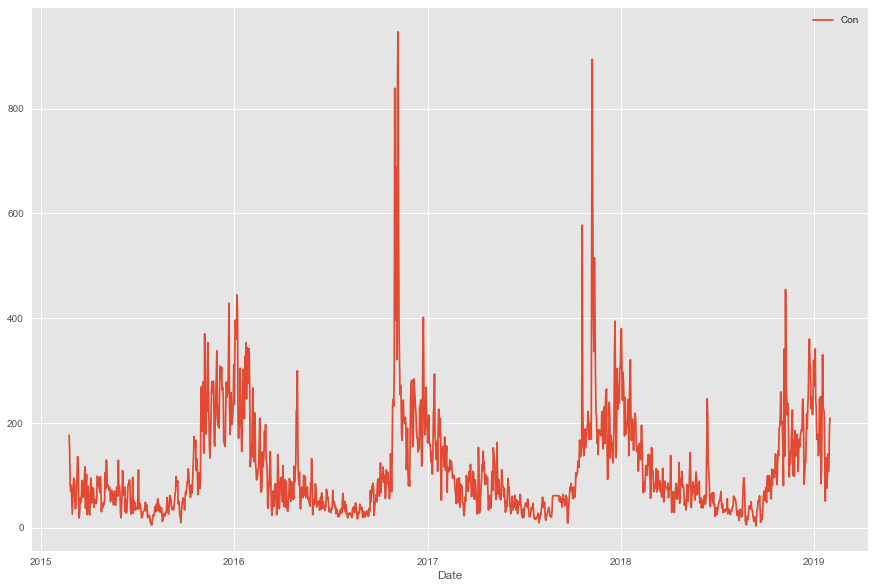

In [57]:
final_ts.plot()

Function to split timeseries into train & test based on duration of forecast targeted

In [58]:
def df_split(timeseries, daysoftestsplit):
    ts = timeseries
    #Creating Train, Test
    split = len(ts) - daysoftestsplit
    train = ts[0:split]
    test = ts[split:]
    print('Dataset %d, Test %d' % (len(train), len(test)))
    train = train.Con
    test = test.Con
    return(train, test)

Dataset 1168, Test 270


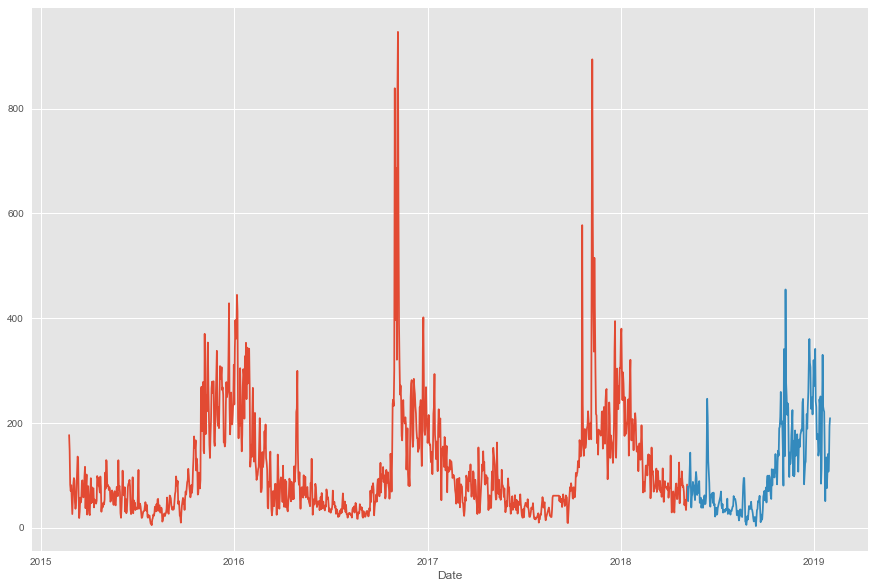

In [59]:
train, test = df_split(final_ts, 30*9)
train.plot()
test.plot()

In [60]:
#Log transformation for better scale and predictibility
train, test = np.log(train),  np.log(test)

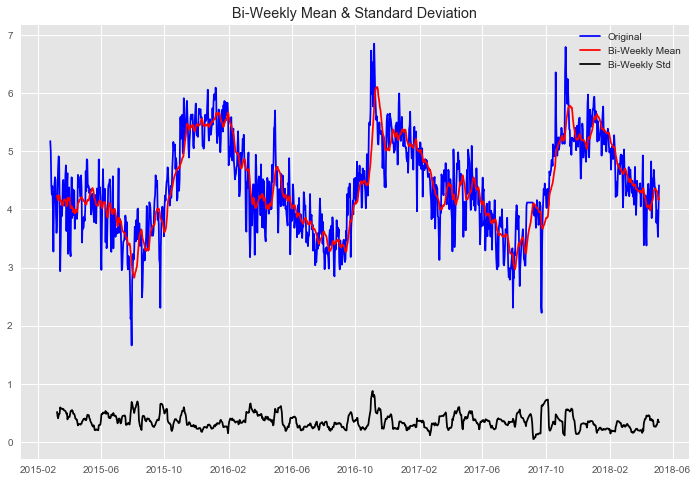

Results of Dickey-Fuller Test:
Test Statistic                   -3.015078
p-value                           0.033510
#Lags Used                        9.000000
Number of Observations Used    1158.000000
Critical Value (1%)              -3.436010
Critical Value (5%)              -2.864039
Critical Value (10%)             -2.568101
dtype: float64


In [61]:
#checking for stationarity
test_stationarity(train)

Function to find order of ARIMA

In [62]:
def find_order(train):
    for p in range(5):
        for d in range(2):
            for q in range(5):
                try:
                    arima_mod=sm.tsa.ARIMA(np.asarray(train),(p,d,q)).fit(transparams=True)
                    aic=arima_mod.aic
                    param= (p,d,q) 
                    print('ARIMA{} --- AIC {}'.format(param, aic))
                    aic.append(aic)
                    pdq.append(param)
                except:
                    pass
    return(aic, param)

In [63]:
aic, param = find_order(train)

ARIMA(0, 0, 0) --- AIC 2777.3093460793675
ARIMA(0, 0, 1) --- AIC 1809.7600778389938
ARIMA(0, 0, 2) --- AIC 1458.5435394433034
ARIMA(0, 0, 4) --- AIC 1164.00393107555
ARIMA(0, 1, 0) --- AIC 943.5070501304199
ARIMA(0, 1, 1) --- AIC 910.4734920954056
ARIMA(0, 1, 2) --- AIC 794.9400309629464
ARIMA(0, 1, 3) --- AIC 784.5086797812282
ARIMA(0, 1, 4) --- AIC 779.7348273617986
ARIMA(1, 0, 0) --- AIC 885.0207680394196
ARIMA(1, 0, 1) --- AIC 875.3205831180826
ARIMA(1, 0, 2) --- AIC 788.4659017814374
ARIMA(1, 0, 3) --- AIC 780.7911966449801
ARIMA(1, 0, 4) --- AIC 777.0819080639535
ARIMA(1, 1, 0) --- AIC 928.9035337827636
ARIMA(1, 1, 1) --- AIC 793.9533266529388
ARIMA(1, 1, 2) --- AIC 778.3797369353515
ARIMA(1, 1, 3) --- AIC 778.4500918522763
ARIMA(1, 1, 4) --- AIC 780.2117260721125
ARIMA(2, 0, 0) --- AIC 881.1948490158579
ARIMA(2, 0, 1) --- AIC 791.9899277315853
ARIMA(2, 0, 2) --- AIC 775.9007137382018
ARIMA(2, 0, 3) --- AIC 776.2572482814799
ARIMA(2, 0, 4) --- AIC 778.0060971822118
ARIMA(2, 1, 0)

/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 4) --- AIC 763.9094698969429
ARIMA(4, 0, 0) --- AIC 818.6512064301442
ARIMA(4, 0, 1) --- AIC 777.3005014371888
ARIMA(4, 0, 2) --- AIC 777.9741829500967


/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 3) --- AIC 763.7053560377399


/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 4) --- AIC 779.1618147873969
ARIMA(4, 1, 0) --- AIC 821.7600525164694
ARIMA(4, 1, 1) --- AIC 780.7313620245186
ARIMA(4, 1, 2) --- AIC 782.1832414224414


/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 3) --- AIC 782.2312019611027
ARIMA(4, 1, 4) --- AIC 783.5699032094353


/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [64]:
aic, param

(783.5699032094353, (4, 1, 4))

Fitting the model with seasonal trasnformation

In [65]:
def model_arima(train):
    seasonality = 365
    train_1 = diff_ts(train, seasonality)
    p, d, q = param[0], param[1], param[2]
    model = ARIMA(train_1, order=(p,d,q))
    model_fit = model.fit()
    print(model_fit.summary())
    return(model_fit)

In [66]:
model_fit = model_arima(train)

/Users/Radhika/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  802
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -510.189
Method:                       css-mle   S.D. of innovations              0.456
Date:                Sun, 31 Mar 2019   AIC                           1040.378
Time:                        18:45:35   BIC                           1087.249
Sample:                             1   HQIC                          1058.381
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.518e-05      0.000     -0.094      0.925      -0.001       0.001
ar.L1.D.y      0.4240      0.081      5.215      0.000       0.265       0.583
ar.L2.D.y     -0.1340      0.085     -1.570      0.1

Function to forecast

In [67]:
def forecast_arima(train, test, model_fit, daysoftestsplit):
    daysoftestsplit = daysoftestsplit
    forecast = model_fit.forecast(steps=daysoftestsplit)[0]
    #inverting the forecast for seasonality
    history = [x for x in train]
    frcst = []
    day = 1
    for y in forecast:
        inverted = inverse_diff(history, y, seasonality)
        print('Day %d: %f' % (day, inverted))
        history.append(inverted)
        frcst.append(inverted)
        day += 1
    frcst_df = pd.DataFrame(frcst, index=test.index)
    frcst_df = frcst_df.reset_index()
    frcst_df = frcst_df.rename(columns={ frcst_df.columns[1]:'Con'})
    frcst_df = frcst_df.set_index('Date')
    frcst_s = pd.Series(frcst_df.Con, index=frcst_df.index)
    return(frcst_s)

In [68]:
frcst = forecast_arima(train, test, model_fit, 30*9)

Day 1: 4.437042
Day 2: 4.361563
Day 3: 3.969735
Day 4: 3.932724
Day 5: 4.078096
Day 6: 5.093965
Day 7: 4.513158
Day 8: 4.358466
Day 9: 4.196309
Day 10: 4.643649
Day 11: 4.132246
Day 12: 4.231079
Day 13: 3.906602
Day 14: 4.196602
Day 15: 4.820177
Day 16: 4.494795
Day 17: 4.382921
Day 18: 4.276028
Day 19: 4.084433
Day 20: 4.412001
Day 21: 3.970282
Day 22: 3.410590
Day 23: 3.601582
Day 24: 3.917130
Day 25: 3.778128
Day 26: 4.366964
Day 27: 4.575423
Day 28: 4.277695
Day 29: 4.335689
Day 30: 3.773234
Day 31: 3.893695
Day 32: 3.333844
Day 33: 3.538032
Day 34: 4.040237
Day 35: 4.138717
Day 36: 3.609948
Day 37: 3.897554
Day 38: 3.665243
Day 39: 3.794827
Day 40: 4.162110
Day 41: 3.831685
Day 42: 3.581276
Day 43: 3.989899
Day 44: 3.931010
Day 45: 3.324826
Day 46: 3.966162
Day 47: 3.907908
Day 48: 3.795398
Day 49: 3.905066
Day 50: 4.173236
Day 51: 3.876019
Day 52: 3.585077
Day 53: 3.187213
Day 54: 2.991727
Day 55: 2.978281
Day 56: 3.626372
Day 57: 3.064184
Day 58: 3.718438
Day 59: 3.767927
Day 60

Checking for Error rate or Efficiancy

In [69]:
def check_rmse(test, frcst):
    #train.plot(label='train')
    #test.plot(label='test')
    #frcst.plot(label='forecast')
    #plt.legend()
    #plt.show()
    def RMSE(predicted, actual):
        mse = (predicted - actual)**2
        rmse = np.sqrt(mse.sum()/mse.count())
        return rmse

    result = RMSE(test,frcst)
    return(result)

In [70]:
check_rmse(test,frcst)

0.6042283525403775

The prediction is pretty close to the actuals, targeting at a valuable Forecasting model, i.e the Air Quality (RMSE)
can be predicted with reasonable power atleast for the next 9 months

In [71]:
#converting back to actuals
def unlog_series(series):
    series = np.exp(series)
    return(series)

In [72]:
#Viz_series and returning accuracy
def viz_series(train, test, forecast):
    tr = unlog_series(train)
    ts = unlog_series(test)
    fr = unlog_series(frcst)
    tr.plot(label = 'train')
    ts.plot(label = 'test')
    fr.plot(label='forecast')
    plt.legend()
    plt.show()
    accu = check_rmse(ts,fr)
    return(accu)

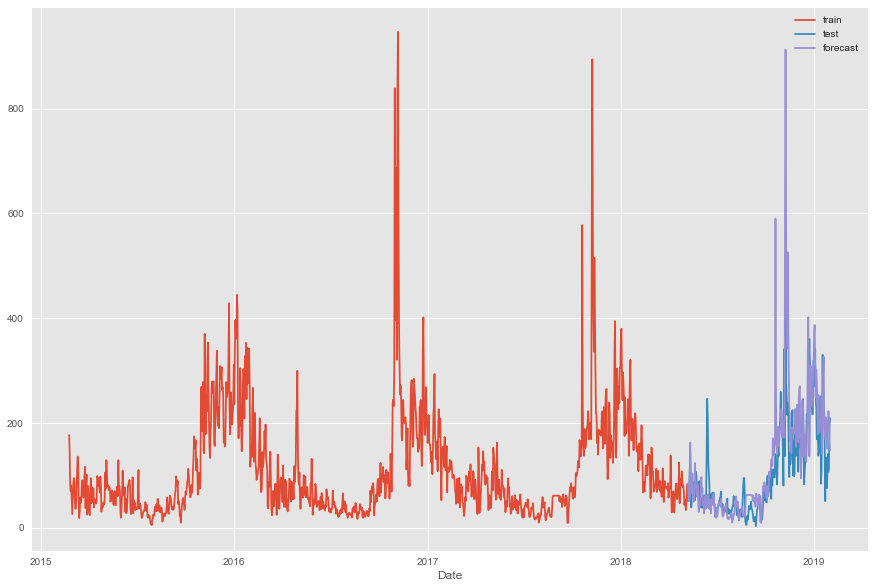

78.10908871047222

In [73]:
viz_series(train, test, forecast)

Prediction of the peak was fairly well, considering the Air Quality Index(AQI) above '300' RSMP is what affects daily life of city in-habitants.

So, now lets predict the first instance when Delhis Air Quality is foreacasted to be Un-brethable?

As the data is uploaded on monthly basis, in the portal. 
Running this module at the end of each month will give clear indication if there is possibility of Bad Air Quality in the city for the month.
i.e. Running the notebook on end of Sept/Oct for next 30/60 days will fairly predict the week of the RSPM above 350.

End of Notebook